<a href="https://colab.research.google.com/github/alejandramcr/Proyecto_DS_Smart_Energy_Forecasting/blob/main/skforecast_Demanda_Electrica_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pronóstico de Demanda Eléctrica con Skforecast

Este proyecto implementa un flujo completo de forecasting de series temporales para la demanda eléctrica en Perú, utilizando la librería skforecast.

Septiembre 2025

Bootcamp Xperience

Realizado por Alejandra Cruz R.

## Paquetes


In [ ]:
# skforecast es una librería especializada en modelado de series temporales
# con algoritmos de machine learning como Random Forest, XGBoost, LightGBM, etc.
# El flag "-q" hace que la instalación sea silenciosa (quiet).

In [ ]:
pip install -q skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 34.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Analisis Exploratorio

### Cargando datos

In [ ]:
# URL del archivo en GitHub (usando el enlace raw)
url = "https://raw.githubusercontent.com/alejandramcr/Proyecto_DS_Smart_Energy_Forecasting/main/DemandaCOES_.xlsx"

# Leer el Excel desde GitHub
data = pd.read_excel(url, skiprows=3)
#El parámetro skiprows=3 le dice a pandas que ignore las primeras 3 filas del archivo

[Datos](https://www.coes.org.pe/Portal/portalinformacion/demanda?indicador=maxima)

In [ ]:
#Información del DataFrame:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29232 entries, 0 to 29231
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FECHA      29232 non-null  object 
 1   EJECUTADO  29232 non-null  float64
dtypes: float64(1), object(1)
memory usage: 456.9+ KB


**Observaciones:**

El dataset está limpio en cuanto a valores faltantes.

La columna FECHA requiere conversión a datetime para trabajar correctamente en análisis temporal.

La columna EJECUTADO es la variable objetivo (la demanda eléctrica) y ya está en formato numérico correcto.

Con 29k registros, se trata de un dataset lo suficientemente grande para capturar patrones diarios, semanales y estacionales.

In [ ]:
#Estadísticos descriptivos:
data.describe()

,EJECUTADO
count,29232.000000
mean,6813.207256
std,573.210998
min,4953.463810
25%,6305.686240
50%,6914.043845
75%,7281.350670
max,8304.612840


**Observaciones clave de este resultado**

La demanda oscila entre ≈ 4953 MW y ≈ 8304 MW, con un rango de más de 3300 MW.

El consumo medio (≈ 6813 MW) está muy cercano a la mediana, lo que indica que no hay una asimetría fuerte.

La desviación estándar es significativa (≈ 573), mostrando alta variabilidad diaria y semanal.

Hay un patrón claro de consumo bajo (≈ 5000–6000 MW) y consumo alto (≈ 7000–8000 MW), lo cual se relaciona con los ciclos horarios y estacionales típicos en la electricidad.

### Formato de tiempo

In [ ]:
# Preparación de la serie temporal de demanda eléctrica
# -------------------------------------------------------------------
# Este bloque de código transforma el dataset original en un formato
# adecuado para análisis de series temporales. Las operaciones incluyen:
# 1. Conversión de la columna 'FECHA' a tipo datetime para manejar fechas.
# 2. Establecimiento de 'FECHA' como índice del DataFrame.
# 3. Renombrado de la columna 'EJECUTADO' a 'Demand' para mayor claridad.
# 4. Ajuste de la frecuencia temporal a 30 minutos, garantizando intervalos
#    regulares en la serie.
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d/%m/%Y %H:%M')
data.set_index('FECHA',inplace=True)
data.rename(columns={'EJECUTADO':'Demand'},inplace=True)
data = data.asfreq("30min")
data.head()

,Demand
FECHA,
2023-01-01 00:30:00,6120.78000
2023-01-01 01:00:00,6010.91339
2023-01-01 01:30:00,5946.83300
2023-01-01 02:00:00,5846.17000
2023-01-01 02:30:00,5756.13500


In [ ]:
data.index

DatetimeIndex(['2023-01-01 00:30:00', '2023-01-01 01:00:00',
               '2023-01-01 01:30:00', '2023-01-01 02:00:00',
               '2023-01-01 02:30:00', '2023-01-01 03:00:00',
               '2023-01-01 03:30:00', '2023-01-01 04:00:00',
               '2023-01-01 04:30:00', '2023-01-01 05:00:00',
               ...
               '2024-08-31 19:30:00', '2024-08-31 20:00:00',
               '2024-08-31 20:30:00', '2024-08-31 21:00:00',
               '2024-08-31 21:30:00', '2024-08-31 22:00:00',
               '2024-08-31 22:30:00', '2024-08-31 23:00:00',
               '2024-08-31 23:30:00', '2024-09-01 00:00:00'],
              dtype='datetime64[ns]', name='FECHA', length=29232, freq='30min')

In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

np.True_

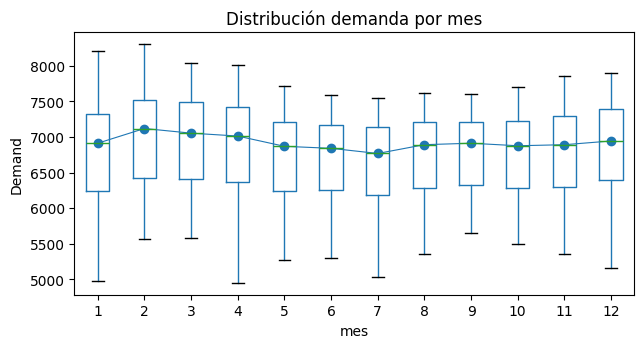

In [ ]:
#Estacionalidad anual de la demanda eléctrica
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data['mes'] = data.index.month
data.boxplot(column='Demand', by='mes', ax=ax,)
data.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');


**Análisis de la Gráfica**

La gráfica muestra la distribución del consumo de energía mes a mes. Cada caja representa la dispersión de la demanda durante un mes en particular.

Valores Extremos: Los "bigotes" de cada caja indican el rango de la mayoría de los datos, mientras que los puntos fuera de los bigotes son valores atípicos (outliers), que representan picos o valles de demanda inusuales.

Mediana: La línea verde que conecta los puntos azules representa la mediana de la demanda para cada mes. La mediana es un indicador de la tendencia central de la demanda.

Estacionalidad: La gráfica confirma un patrón de estacionalidad anual. La demanda parece ser más alta en los meses de verano (alrededor de enero a marzo y de octubre a diciembre) y más baja en los meses de invierno (de junio a septiembre). Esto es consistente con la necesidad de aire acondicionado en los meses más calurosos y la menor actividad económica en días festivos y vacaciones.

Este análisis es muy útil para el pronóstico, ya que valida que la estacionalidad anual es un factor importante que debe ser considerado en un modelo predictivo.

### Visualizando Serie

**Visualización de la serie temporal de la demanda eléctrica**

En este bloque se grafica la variable 'Demand', que representa el consumo eléctrico (MW),
a lo largo del tiempo con una resolución de 30 minutos.
El objetivo de esta visualización es observar la evolución del consumo,
identificar patrones generales, fluctuaciones y posibles tendencias.


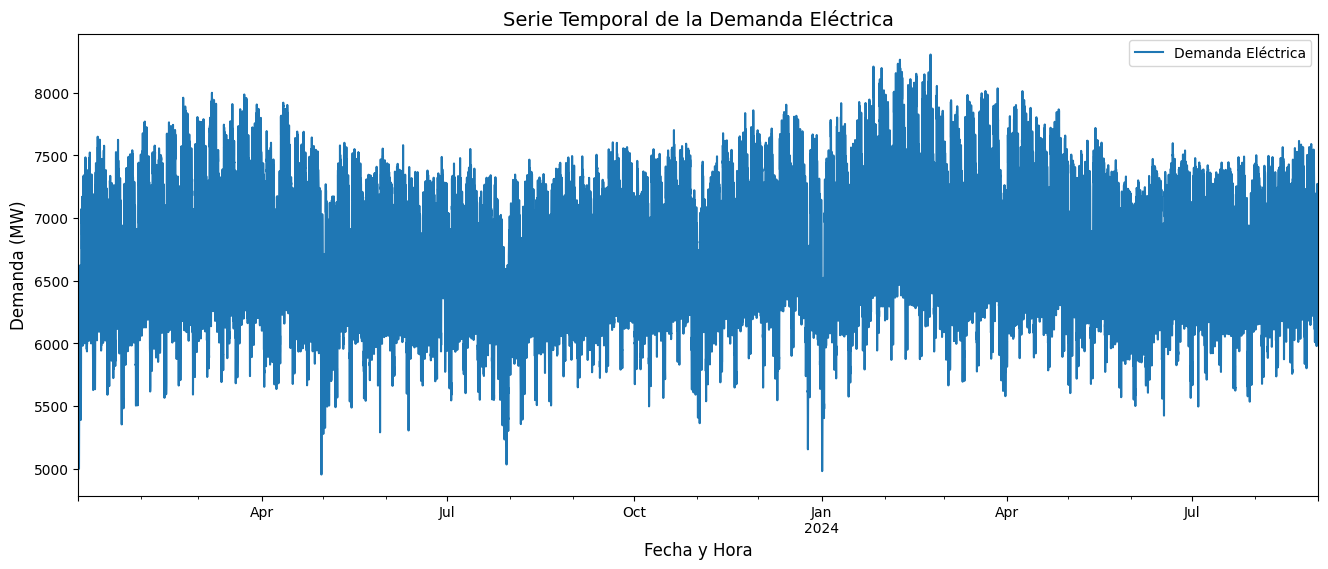

In [ ]:
data.Demand.plot(figsize=(16,6), label="Demanda Eléctrica")

plt.title("Serie Temporal de la Demanda Eléctrica", fontsize=14)
plt.xlabel("Fecha y Hora", fontsize=12)
plt.ylabel("Demanda (MW)", fontsize=12)
plt.legend()
plt.show()


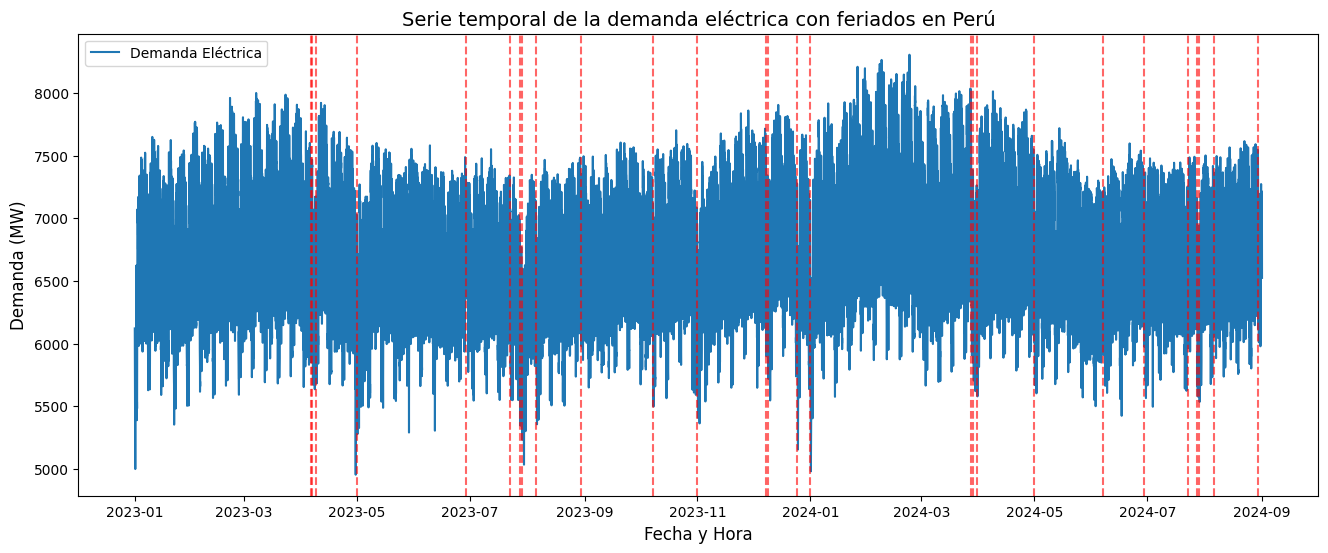

In [ ]:
# 1. Importar la librería holidays
import holidays

# 2. Crear un objeto de feriados para Perú en los años 2023 y 2024
pe = holidays.Peru(years=[2023, 2024])

# fechas en una lista ordenada
feriados_peru = sorted(pe.keys())

feriados_peru = [fecha.strftime("%Y-%m-%d") for fecha in sorted(pe.keys())]
# Convertir a formato datetime
feriados_peru = pd.to_datetime(feriados_peru)
# Crear columna booleana indicando si la fecha es feriado
data["Feriado"] = data.index.normalize().isin(feriados_peru)

# Grafica de la demanda eléctrica
plt.figure(figsize=(16,6))
plt.plot(data.index, data["Demand"], label="Demanda Eléctrica")

# Dias feriados con líneas verticales
for fecha in feriados_peru:
    if fecha in data.index:  # solo si la fecha está en la serie
        plt.axvline(x=fecha, color="red", linestyle="--", alpha=0.6)

# Graficar
plt.title("Serie temporal de la demanda eléctrica con feriados en Perú", fontsize=14)
plt.xlabel("Fecha y Hora", fontsize=12)
plt.ylabel("Demanda (MW)", fontsize=12)
plt.legend()
plt.show()

In [ ]:
feriados_peru

DatetimeIndex(['2023-01-01', '2023-04-06', '2023-04-07', '2023-04-09',
               '2023-05-01', '2023-06-29', '2023-07-23', '2023-07-28',
               '2023-07-29', '2023-08-06', '2023-08-30', '2023-10-08',
               '2023-11-01', '2023-12-08', '2023-12-09', '2023-12-25',
               '2024-01-01', '2024-03-28', '2024-03-29', '2024-03-31',
               '2024-05-01', '2024-06-07', '2024-06-29', '2024-07-23',
               '2024-07-28', '2024-07-29', '2024-08-06', '2024-08-30',
               '2024-10-08', '2024-11-01', '2024-12-08', '2024-12-09',
               '2024-12-25'],
              dtype='datetime64[ns]', freq=None)

**Observaciones del resultado de la gráfica:**

Los feriados, representados por las líneas rojas discontinuas en la gráfica, parecen coincidir con una disminución notable en la demanda de energía eléctrica. Esto se observa como una caída en la curva azul de "Demanda Eléctrica" en los días marcados.

La gráfica muestra una clara estacionalidad diaria y semanal, con picos altos durante los días laborables y caídas más pronunciadas durante los fines de semana. Las caídas de demanda durante los feriados se parecen a las que ocurren los fines de semana, lo que sugiere que las actividades asociadas a los días festivos (como el cierre de negocios, industrias y oficinas) tienen un impacto similar al de los días no laborables. Esta información es muy útil para la planificación y predicción de la demanda, ya que permite a las empresas eléctricas anticipar y gestionar los picos de consumo de manera más eficiente.

### Analisis de tendencia

**Análisis de tendencia de la demanda eléctrica**

Este bloque grafica la serie temporal de la demanda eléctrica junto con
su media móvil de 24 horas. La serie original permite observar las
fluctuaciones propias del consumo cada media hora, mientras que la
media móvil suaviza estas variaciones para resaltar la tendencia diaria.
Con esta visualización se facilita la identificación de patrones de
consumo y posibles cambios en el comportamiento de la serie.

**La media móvil**

es una técnica estadística que se utiliza para suavizar series temporales y revelar su tendencia subyacente. El valor de la media móvil se calcula tomando el promedio de los datos dentro de una ventana de tiempo específica y moviendo esa ventana a lo largo de la serie. En este caso, la ventana es de 24 horas, lo que corresponde a 48 puntos de datos si los datos son cada media hora.

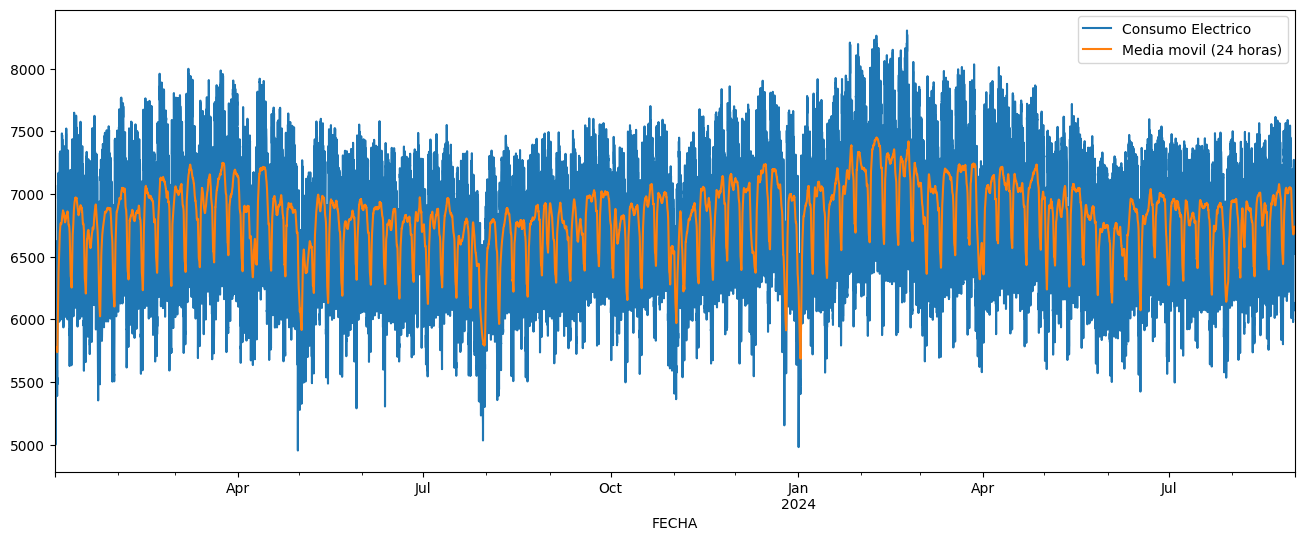

In [ ]:
data.Demand.plot(figsize=(16,6),label="Consumo Electrico")
data.Demand.rolling(48).mean().plot(label='Media movil (24 horas)')
plt.legend()
plt.show()


**Observación de los valores de la gráfica:**

Se muestra la serie temporal del Consumo Eléctrico junto con su media móvil de 24 horas.

La línea naranja, que es la media móvil de 24 horas, es una versión suavizada de los datos de consumo. Esta línea naranja sigue la tendencia general de la demanda, eliminando las variaciones de alta frecuencia (como los cambios cada media hora).

El análisis de la gráfica nos permite observar varios aspectos:

Tendencia General: La media móvil muestra que la demanda de energía tiende a ser más baja en los meses de invierno (mediados de 2023 y principios de 2024) y más alta en los meses de verano.

Patrón Semanal: A pesar de que la media móvil suaviza los picos diarios, todavía se observan fluctuaciones cíclicas que quizá corresponden a patrones de consumo semanales, con una demanda más baja en los fines de semana.

En puntos específicos, la media móvil también puede ayudarnos a identificar caídas inusuales en la demanda, que podrían corresponder a días festivos o eventos especiales.

**Análisis de la tendencia semanal del consumo eléctrico**

Este bloque grafica el consumo eléctrico real y superpone una media móvil de 7 días, lo que permite observar la tendencia semanal de la demanda y detectar patrones más amplios que no se aprecian en el análisis diario.

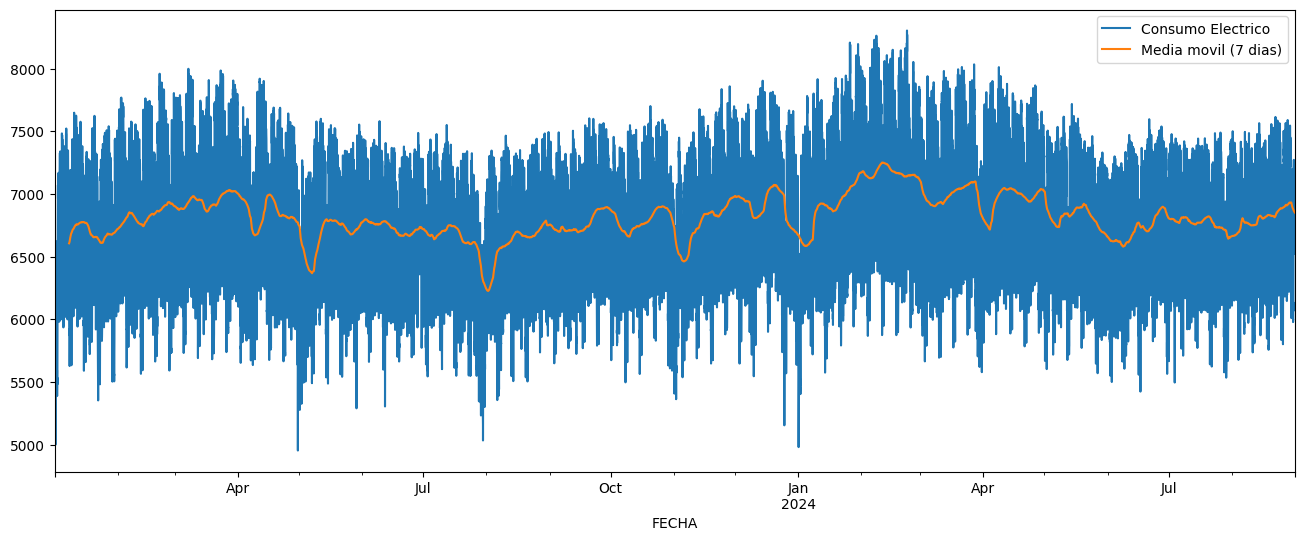

In [ ]:
data.Demand.plot(figsize=(16,6),label="Consumo Electrico")
data.Demand.rolling(48*7).mean().plot(label='Media movil (7 dias)')
plt.legend()
plt.show()


**Análisis de la gráfica:**

Esta gráfica del consumo eléctrico junto con una media móvil de 7 días permite un análisis más detallado de las tendencias a largo plazo. A diferencia de la media móvil de 24 horas que suavizaba los patrones diarios, esta de 7 días elimina las fluctuaciones semanales (como las caídas de consumo en fines de semana) para revelar la tendencia estacional de la demanda.

Al observar la gráfica, se pueden extraer las siguientes conclusiones:

Tendencia Estacional Clara: La línea naranja de la media móvil de 7 días muestra una tendencia estacional bien definida. Se observa una disminución de la demanda durante los meses de invierno (alrededor de junio a septiembre en Perú) y un aumento durante el verano (diciembre a marzo). Este patrón es esperable, ya que en el hemisferio sur la demanda eléctrica suele ser menor en invierno debido a la menor necesidad de refrigeración o calefacción.

Patrones a Largo Plazo: Al suavizar la estacionalidad semanal, la media móvil de 7 días revela cambios más lentos en la demanda. Por ejemplo, la línea naranja muestra una subida sostenida a finales de 2023 y principios de 2024, seguida de una meseta y luego un ligero descenso, lo que sugiere una tendencia anual recurrente.

## Featuring engineers

### Efecto Ciclico

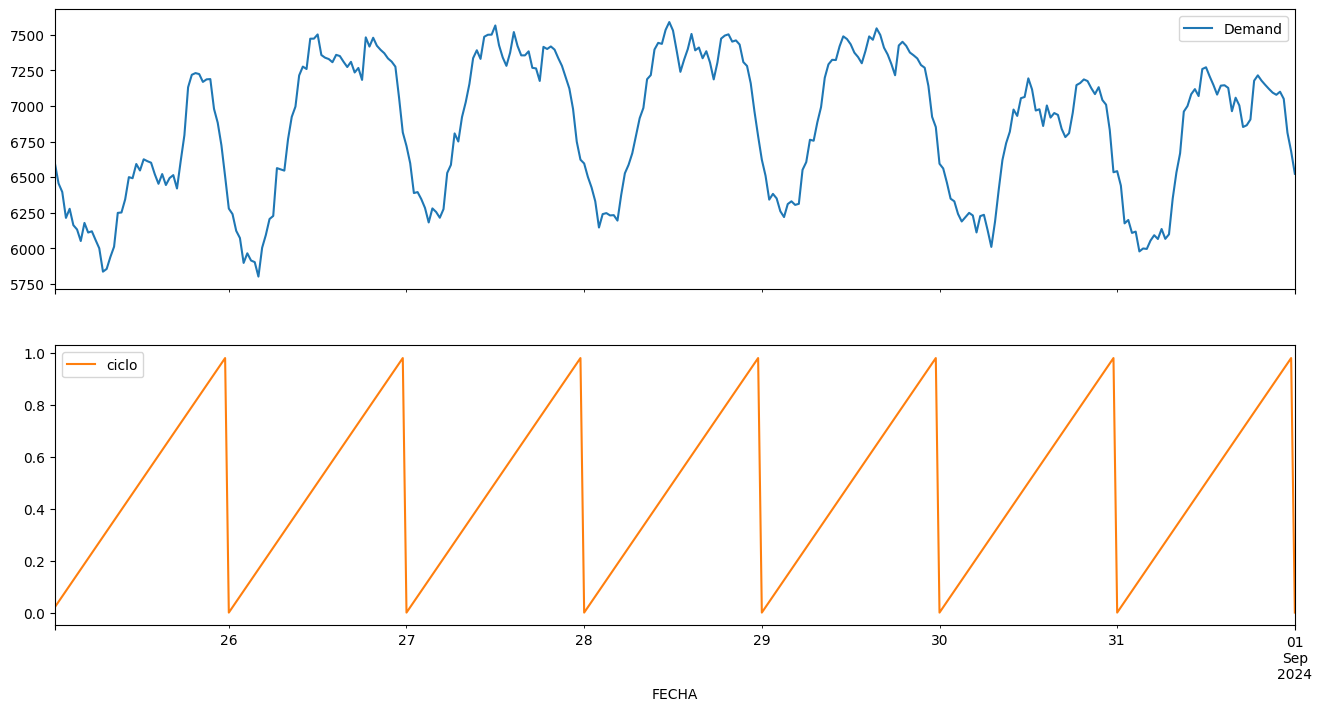

In [ ]:
# -------------------------------------------------------------------
# Efecto cíclico diario basado en la posición intradía de cada registro
# -------------------------------------------------------------------
# Se crea una nueva columna 'ciclo' que representa la posición relativa
# de cada registro dentro del día.
# Para cada timestamp del índice:
#   - Se calculan los minutos transcurridos desde la medianoche: t.hour * 60 + t.minute
#   - Se divide entre el total de minutos del día (24*60 = 1440)
# Resultado: un valor entre 0 y 1
#   - 0 corresponde a las 00:00
#   - 0.5 corresponde al mediodía
#   - Valores cercanos a 1 corresponden a la noche
# -------------------------------------------------------------------
data['ciclo'] = data.index.map(lambda t: (t.hour * 60 + t.minute) / (24*60))


# Visualización de la demanda y el ciclo diario para los últimos 7 días

data[['Demand', 'ciclo']][-48*7:].plot(figsize=(16,8), subplots=True)
plt.show()


**Análisis de la gráfica:**

Esta gráfica muestra el resultado de un "feature engineering", que es el proceso de crear nuevas variables a partir de datos existentes. En este caso, se ha creado una variable cíclica a partir de la fecha y hora para capturar el patrón diario de la demanda de energía.

La gráfica superior, etiquetada como Demand, muestra el consumo de energía en los últimos siete días. Se puede observar claramente un patrón de subida y bajada que se repite cada 24 horas. Los picos de consumo se dan durante el día, y los valles se dan durante la noche.

La gráfica inferior, etiquetada como ciclo, es la nueva variable creada. Esta variable va de 0 a 1, donde:

0 representa el inicio del día (medianoche, 00:00).

1 representa el final del día.

Al superponer ambas gráficas, se hace evidente que el patrón de la demanda (la gráfica superior) está directamente relacionado con el ciclo diario (la gráfica inferior). Esto significa que la demanda de energía sube y baja de manera predecible en función de la hora del día. Esta nueva variable (ciclo) es muy útil para modelos de aprendizaje automático porque les proporciona una forma numérica de entender y predecir la estacionalidad diaria, que de otro modo sería difícil de capturar.

### Efecto Diario

In [ ]:
# Efecto Diario en la Demanda Eléctrica
# Se define un diccionario que traduce los nombres de los días de la semana
days_translation = {
    'Monday': '1Lunes',
    'Tuesday': '2Martes',
    'Wednesday': '3Miércoles',
    'Thursday': '4Jueves',
    'Friday': '5Viernes',
    'Saturday': '6Sábado',
    'Sunday': '0Domingo'
}

In [ ]:
# Se crea una nueva columna 'dia' en el DataFrame 'data'
# que asigna a cada fecha su día de la semana en español,
# usando el diccionario 'days_translation'.
data['dia'] = data.index.day_name().map(days_translation)


In [ ]:
data.index.day_name().map(days_translation)

Index(['0Domingo', '0Domingo', '0Domingo', '0Domingo', '0Domingo', '0Domingo',
       '0Domingo', '0Domingo', '0Domingo', '0Domingo',
       ...
       '6Sábado', '6Sábado', '6Sábado', '6Sábado', '6Sábado', '6Sábado',
       '6Sábado', '6Sábado', '6Sábado', '0Domingo'],
      dtype='object', name='FECHA', length=29232)

In [ ]:
# Se generan variables dummy (one-hot encoding) para la
# columna 'dia'. Esto significa que se crea una columna
# binaria para cada día de la semana:
#   - Si el registro corresponde a ese día, se marca con 1.
#   - En caso contrario, se marca con 0.
# El DataFrame resultante se almacena en 'data2'.
data['dia'] = data.index.day_name().map(days_translation)
data2 = pd.get_dummies(data,columns=['dia'], dtype=int)


In [ ]:
data2.columns

Index(['Demand', 'mes', 'Feriado', 'ciclo', 'dia_0Domingo', 'dia_1Lunes',
       'dia_2Martes', 'dia_3Miércoles', 'dia_4Jueves', 'dia_5Viernes',
       'dia_6Sábado'],
      dtype='object')

In [ ]:
data2.head()

,Demand,mes,Feriado,ciclo,dia_0Domingo,dia_1Lunes,dia_2Martes,dia_3Miércoles,dia_4Jueves,dia_5Viernes,dia_6Sábado
FECHA,,,,,,,,,,,
2023-01-01 00:30:00,6120.78000,1,True,0.020833,1,0,0,0,0,0,0
2023-01-01 01:00:00,6010.91339,1,True,0.041667,1,0,0,0,0,0,0
2023-01-01 01:30:00,5946.83300,1,True,0.062500,1,0,0,0,0,0,0
2023-01-01 02:00:00,5846.17000,1,True,0.083333,1,0,0,0,0,0,0
2023-01-01 02:30:00,5756.13500,1,True,0.104167,1,0,0,0,0,0,0


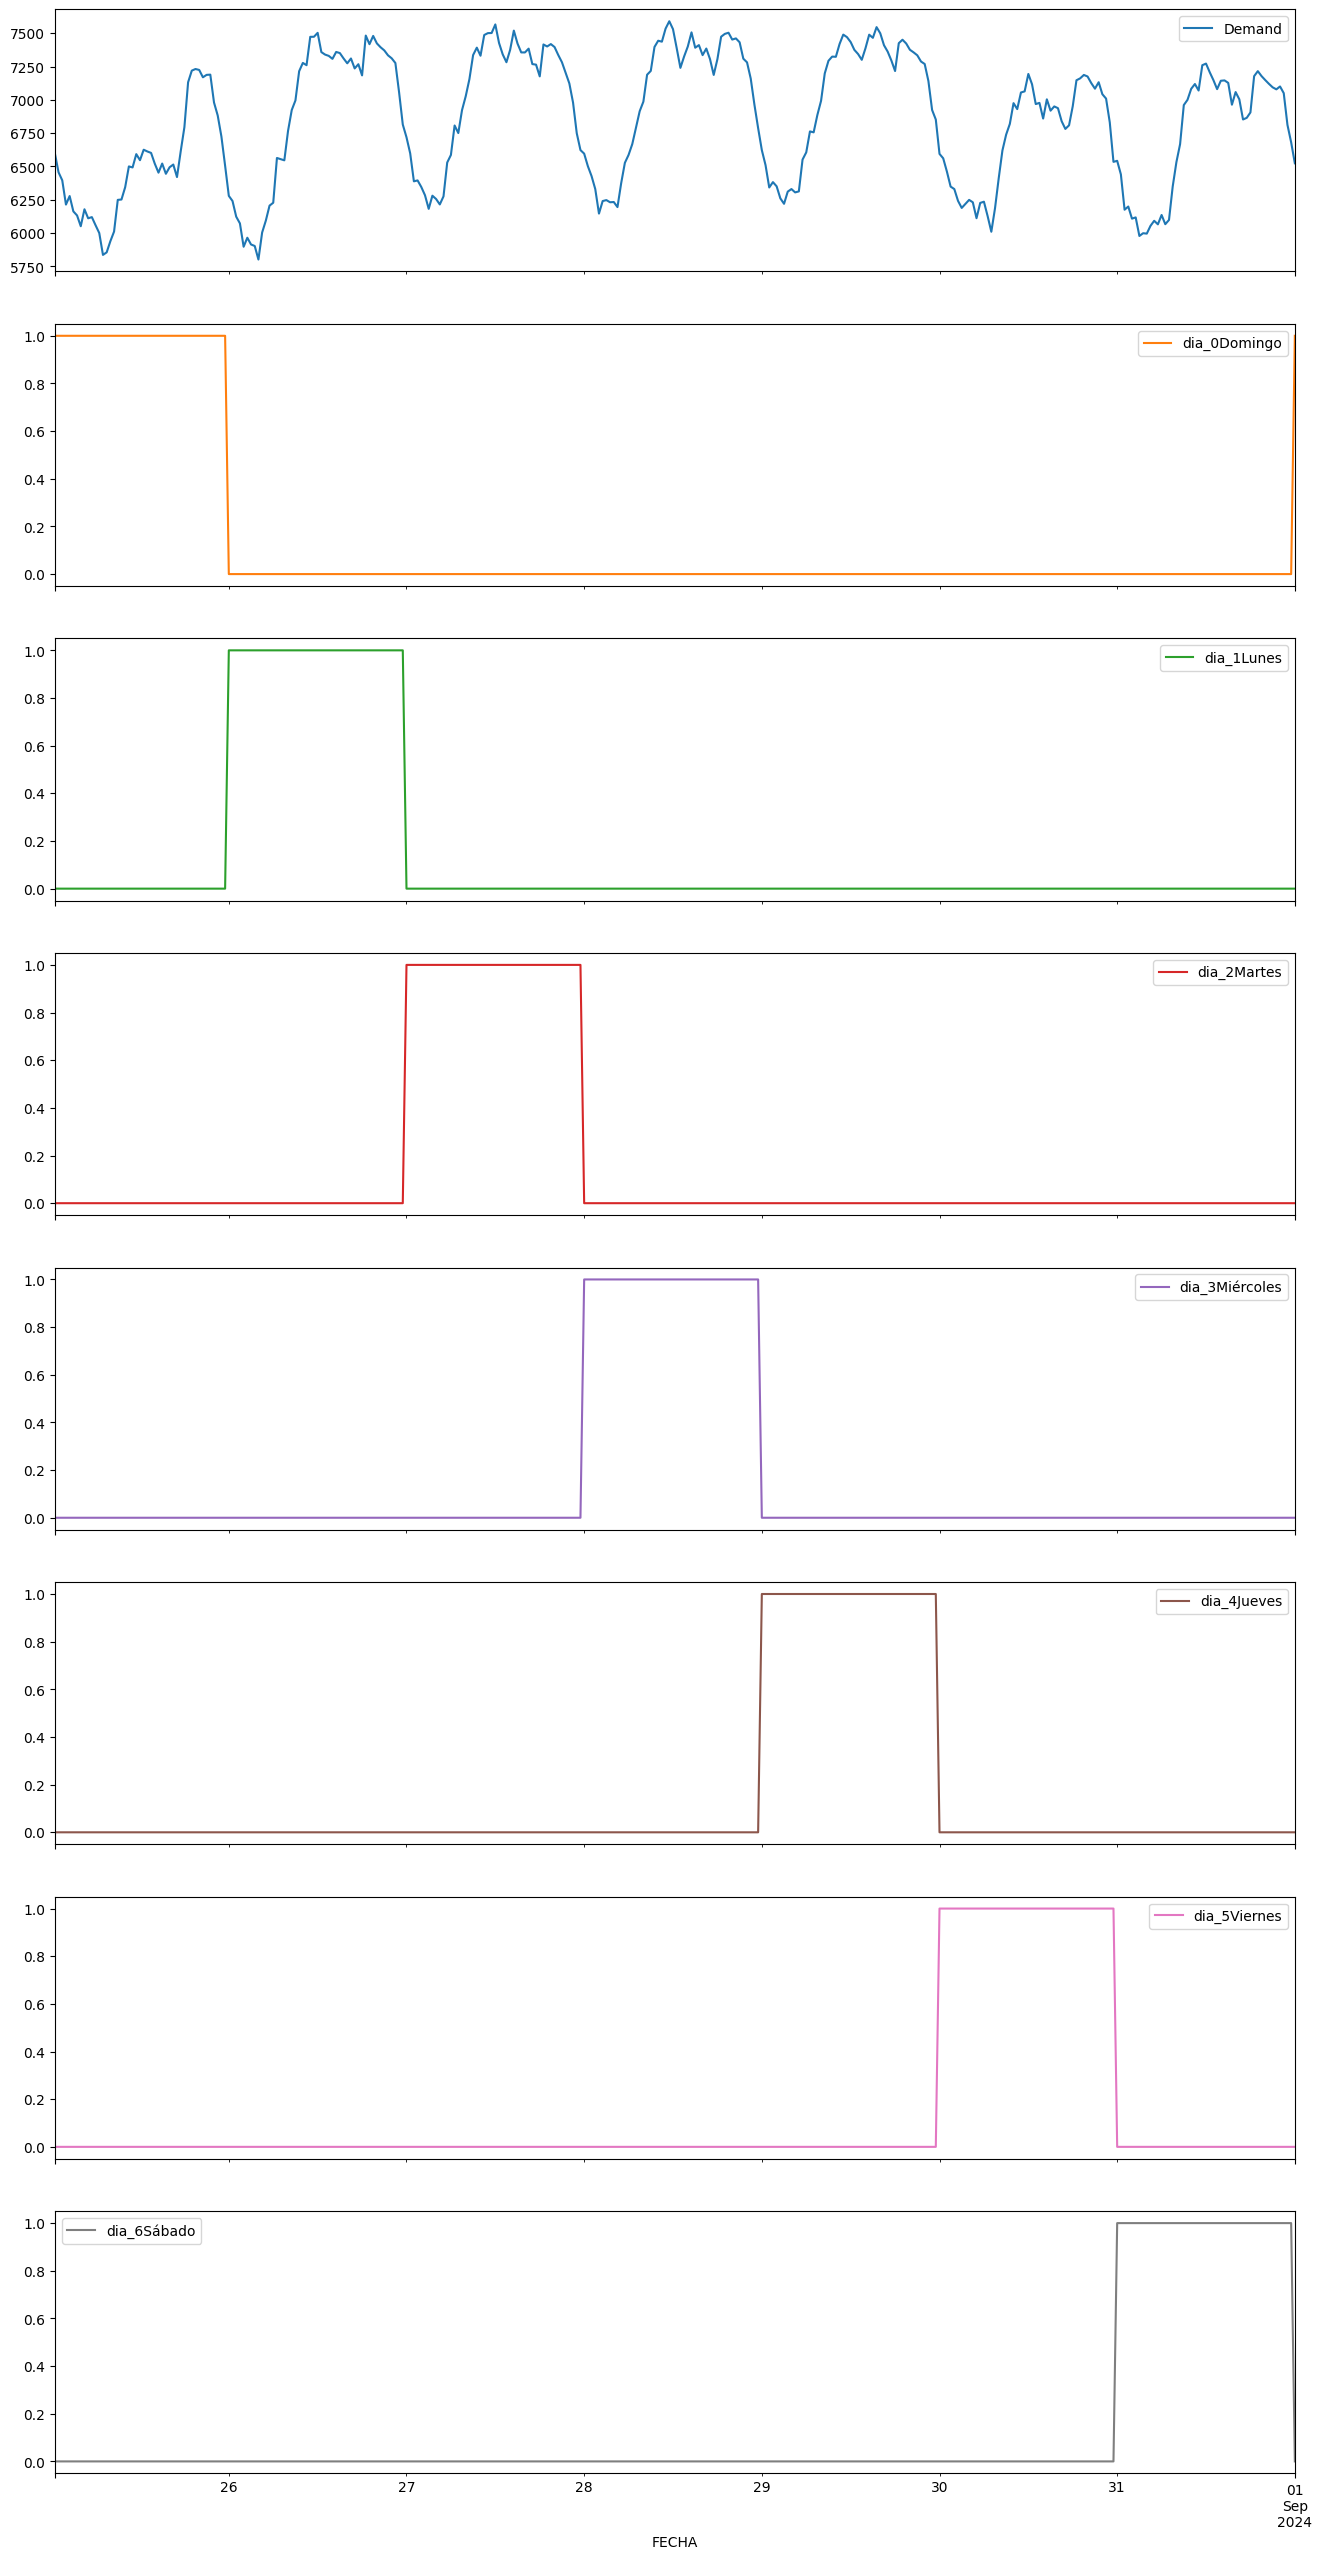

In [ ]:
# Visualización de los últimos 7 días:
# Esto permite ver la relación entre la demanda
# y los días específicos de la semana.
data2[['Demand','dia_0Domingo','dia_1Lunes','dia_2Martes','dia_3Miércoles','dia_4Jueves','dia_5Viernes','dia_6Sábado']][-48*7:].plot(figsize=(16,32),subplots=True)
plt.show()

Se realiza una transformación de los datos para capturar el efecto semanal en la demanda eléctrica. Su objetivo es convertir la información del día de la semana (por ejemplo, "Lunes" o "Domingo") en variables numéricas binarias que los modelos de aprendizaje automático puedan entender.


 Transformación de Días a Variables Binarias: Se utiliza "one-hot encoding" para crear una nueva columna para cada día de la semana. Por ejemplo, la columna dia_1Lunes tendrá un valor de 1 si el registro de demanda corresponde a un lunes, y 0 en cualquier otro día. Este proceso se repite para cada uno de los siete días de la semana, lo que se conoce como "feature engineering".



**Análisis de la Gráfica:**

Panel Superior (Demand): Muestra el consumo de energía en los últimos siete días. Se puede ver claramente que el patrón de consumo se repite de manera similar de un día a otro, pero con diferencias importantes entre los días laborables y el fin de semana.

Paneles Inferiores (Variables de Días): Cada uno de los paneles inferiores muestra una de las variables binarias creadas. Por ejemplo, el panel dia_1Lunes está en 1 durante el lunes y 0 el resto de la semana, lo que valida la correcta creación de estas variables.

Relación entre las Gráficas: La visualización de los datos demuestra que el patrón de demanda eléctrica varía significativamente dependiendo del día de la semana. Por ejemplo, es probable que la demanda sea más baja los fines de semana (sábado y domingo) en comparación con los días laborables, lo que refleja los patrones de actividad económica y personal. Estas variables binarias son cruciales para un modelo de pronóstico, ya que permiten al modelo "aprender" la diferencia de la demanda entre un lunes y un domingo.

### Efecto Feriado

Para capturar el efecto de los feriados, se utiliza una librería de Python para identificar las fechas de días festivos en Perú. Luego, se crea una nueva columna en el DataFrame que indica si un día es feriado o no.

In [ ]:
import holidays

In [ ]:
pe

{datetime.date(2024, 1, 1): "New Year's Day", datetime.date(2024, 3, 28): 'Maundy Thursday', datetime.date(2024, 3, 29): 'Good Friday', datetime.date(2024, 3, 31): 'Easter Sunday', datetime.date(2024, 5, 1): 'Labor Day', datetime.date(2024, 6, 7): 'Battle of Arica and Flag Day', datetime.date(2024, 6, 29): "Saint Peter and Saint Paul's Day", datetime.date(2024, 7, 23): 'Peruvian Air Force Day', datetime.date(2024, 7, 28): 'Independence Day', datetime.date(2024, 7, 29): 'Great Military Parade Day', datetime.date(2024, 8, 6): 'Battle of Junín Day', datetime.date(2024, 8, 30): 'Rose of Lima Day', datetime.date(2024, 10, 8): 'Battle of Angamos Day', datetime.date(2024, 11, 1): "All Saints' Day", datetime.date(2024, 12, 8): 'Immaculate Conception', datetime.date(2024, 12, 9): 'Battle of Ayacucho Day', datetime.date(2024, 12, 25): 'Christmas Day', datetime.date(2023, 1, 1): "New Year's Day", datetime.date(2023, 4, 6): 'Maundy Thursday', datetime.date(2023, 4, 7): 'Good Friday', datetime.date

In [ ]:
data2.index.normalize().isin(pe).astype(int)

/tmp/ipython-input-374752515.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data2.index.normalize().isin(pe).astype(int)


array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
# Se crea un objeto de la librería 'holidays' para el país de Perú.
pe = holidays.Peru(years=[2023, 2024], observed=True)
data2['feriado'] = data2.index.normalize().isin(pe).astype(int)

/tmp/ipython-input-755936478.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data2['feriado'] = data2.index.normalize().isin(pe).astype(int)


In [ ]:
data2.head()

,Demand,mes,Feriado,ciclo,dia_0Domingo,dia_1Lunes,dia_2Martes,dia_3Miércoles,dia_4Jueves,dia_5Viernes,dia_6Sábado,feriado
FECHA,,,,,,,,,,,,
2023-01-01 00:30:00,6120.78000,1,True,0.020833,1,0,0,0,0,0,0,1
2023-01-01 01:00:00,6010.91339,1,True,0.041667,1,0,0,0,0,0,0,1
2023-01-01 01:30:00,5946.83300,1,True,0.062500,1,0,0,0,0,0,0,1
2023-01-01 02:00:00,5846.17000,1,True,0.083333,1,0,0,0,0,0,0,1
2023-01-01 02:30:00,5756.13500,1,True,0.104167,1,0,0,0,0,0,0,1


In [ ]:

# Se crea una nueva columna 'feriado' que es 1 si la fecha es un feriado, y 0 en caso contrario.
# La función 'map' de pandas se utiliza para aplicar una verificación a cada fecha en el índice.
#data2['feriado'] = data2.index.map(lambda x: 1 if x.date() in pe else 0)

In [ ]:
# Lista de fechas de feriados en Perú
fechas_feriados = [str(fecha) for fecha in pe.keys()]
print(fechas_feriados[:32])

['2024-01-01', '2024-03-28', '2024-03-29', '2024-03-31', '2024-05-01', '2024-06-07', '2024-06-29', '2024-07-23', '2024-07-28', '2024-07-29', '2024-08-06', '2024-08-30', '2024-10-08', '2024-11-01', '2024-12-08', '2024-12-09', '2024-12-25', '2023-01-01', '2023-04-06', '2023-04-07', '2023-04-09', '2023-05-01', '2023-06-29', '2023-07-23', '2023-07-28', '2023-07-29', '2023-08-06', '2023-08-30', '2023-10-08', '2023-11-01', '2023-12-08', '2023-12-09']


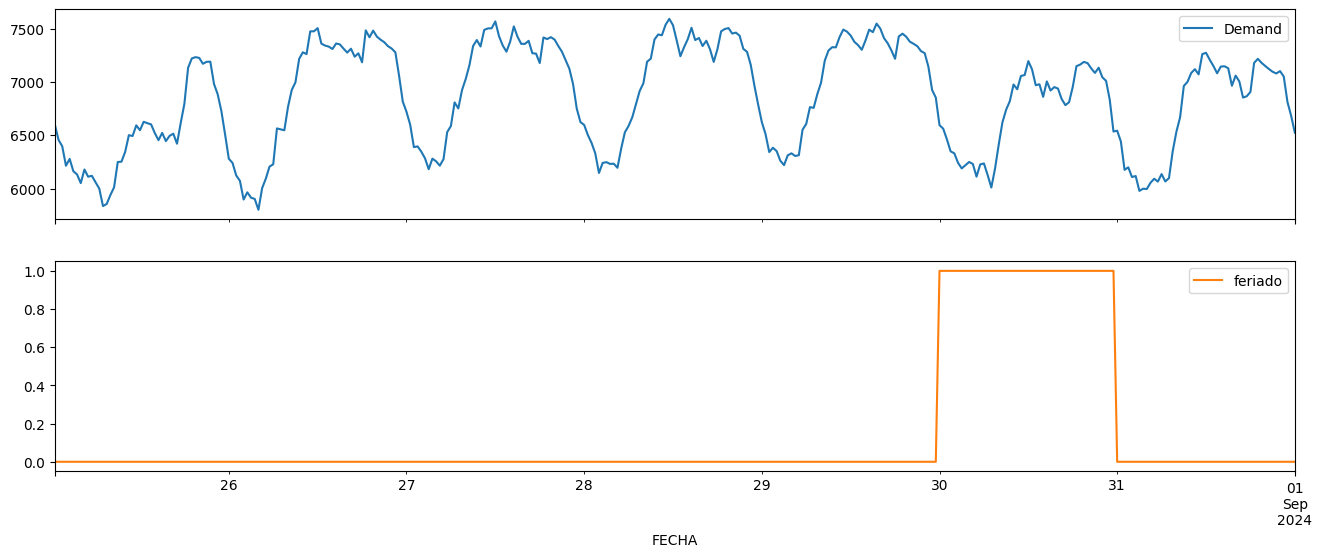

In [ ]:
data2[['Demand','feriado']][-48*7:].plot(figsize=(16,6),subplots=True)
plt.show()


Se creó  una variable binaria que identifique los días feriados y analizar cómo se relacionan con la demanda eléctrica. Esto es otro ejemplo de feature engineering, donde se crea una nueva columna llamada feriado que toma el valor de 1 si la fecha es un día festivo en Perú y 0 si no lo es.

La gráfica muestra los resultados de esta operación. En el panel superior (Demand), puedes ver la serie de tiempo de la demanda eléctrica, que muestra su patrón diario y semanal habitual. En el panel inferior (feriado), se observa la variable binaria creada. Durante la mayor parte de la semana, esta variable es 0, indicando que no hay feriados. Sin embargo, los días 30 y 31 de agosto, la variable cambia a 1. Si se observa el panel de la demanda eléctrica para esos mismos días, se nota una caída significativa en el consumo, similar a la que ocurre los fines de semana. Esto demuestra que los días feriados tienen un impacto negativo en la demanda, probablemente debido a la reducción de actividad en empresas, fábricas y oficinas.

Con esta información, los modelos de pronóstico pueden aprender a anticipar estas caídas en la demanda, mejorando la precisión de sus predicciones.



## Modelamiento  *****

### Particion de datos

**Separación de los datos**

Para el modelado, es necesario dividir los datos en conjuntos de entrenamiento y prueba. El objetivo es predecir la última semana, que es lo que representa la variable steps.

In [ ]:
#steps = 48*7 #separar la ultima semana
# El conjunto de entrenamiento incluye todos los datos excepto la última semana.
#x_train = data2.iloc[:-steps, :]
#y_train = data2['Demand'].iloc[:-steps]

# El conjunto de prueba contiene los datos de la última semana.
#x_test = data2.iloc[-steps:, :]
#y_test = data2['Demand'].iloc[-steps:]

In [ ]:
steps = 48*7#separar la ultima semana
x_train = data2.drop(columns=['Demand'])[:-steps]
x_test  = data2.drop(columns=['Demand'])[-steps:]
y_train = data2['Demand'][:-steps]
y_test  = data2['Demand'][-steps:]

<Axes: xlabel='FECHA'>

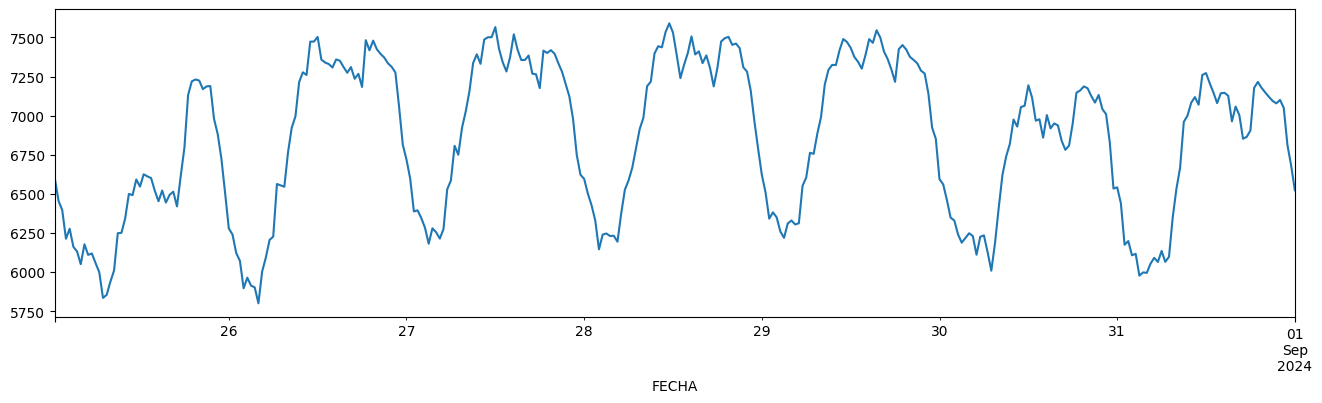

In [ ]:
y_test.plot(figsize=(16,4)) #Queremos predecir la ultima semana de consumo electrico

### Modelo autorregresivo (univariado)

Modelo autorregresivo (univariado)
Un modelo autorregresivo univariado utiliza los valores pasados de la misma variable (Demand en este caso) para predecir valores futuros. En skforecast, este enfoque se implementa usando un objeto ForecasterRecursive con un regresor de machine learning y un conjunto de lags (valores pasados).

El grid_search_forecaster es una técnica para encontrar los mejores hiperparámetros y el mejor conjunto de lags para el modelo. Funciona evaluando diferentes combinaciones en un proceso de validación cruzada.

In [ ]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 48
             )

In [ ]:
# validación cruzada para series temporales
cv = TimeSeriesFold(
      steps              = 48,#la evaluacion es por periodos de 1 dia
      initial_train_size = int(len(x_train) - steps),#inicamos la evaluacion desde hace una semana
      refit              = False,
      fixed_train_size   = False
    )

In [ ]:
# Candidate values for lags
lags_grid = [1,48, 96]

In [ ]:
# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [250],
    'max_depth': [3, 8] #se agrega el valor de la cantidad de profundidad  igual a 3, este es el parametro mas sensible
}

In [ ]:
results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = y_train,
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = True)

Number of models compared: 6.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati


Mejores Parámetros y Lags:

Lags: El mejor modelo utiliza 96 rezagos ([1, 2, ..., 96]). Esto es significativo porque la búsqueda encontró que el mejor rendimiento se obtiene al mirar los datos de los últimos 2 días, lo que es crucial para capturar los patrones diarios y su influencia.

Parameters: La mejor combinación de hiperparámetros para el regresor es {'max_depth': 8, 'n_estimators': 250}. Esto indica que el modelo óptimo es más complejo (mayor profundidad del árbol) que una max_depth de 3, lo que le permite aprender patrones más intrincados en los datos.

**Métrica de Backtesting:**

Backtesting metric: 10589.759750347379. Este es el Error Cuadrático Medio (MSE) promedio que el mejor modelo obtuvo en los 7 pliegues de validación. Este valor es una estimación del rendimiento del modelo en datos que no ha visto.

**Conclusiones**

El modelo es un XGBRegressor autoregresivo con 96 lags y árboles de profundidad 8, lo que le permite capturar dependencias a largo plazo (hasta 2 días).

La estrategia de validación confirma que el modelo generaliza bien en los últimos 7 días, manteniendo un error estable.

Interpretación práctica: el modelo parece capaz de capturar la estacionalidad intradía y patrones de consumo complejos, pero el error (MSE ≈ 10 590) aún puede ser evaluado comparándolo con la variabilidad de la serie para saber si es aceptablemente bajo.


In [ ]:

# Con los mejores hiperparámetros encontrados en la búsqueda,
# se define el modelo final. Por ejemplo, si la búsqueda arrojó

regressor = XGBRegressor(n_estimators=250, max_depth=8, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 96
             )

# El modelo se entrena con todos los datos de entrenamiento.
forecaster.fit(y=y_train)

In [ ]:
# Se realizan las predicciones para el conjunto de prueba (la última semana).
predictions = forecaster.predict(steps=steps)

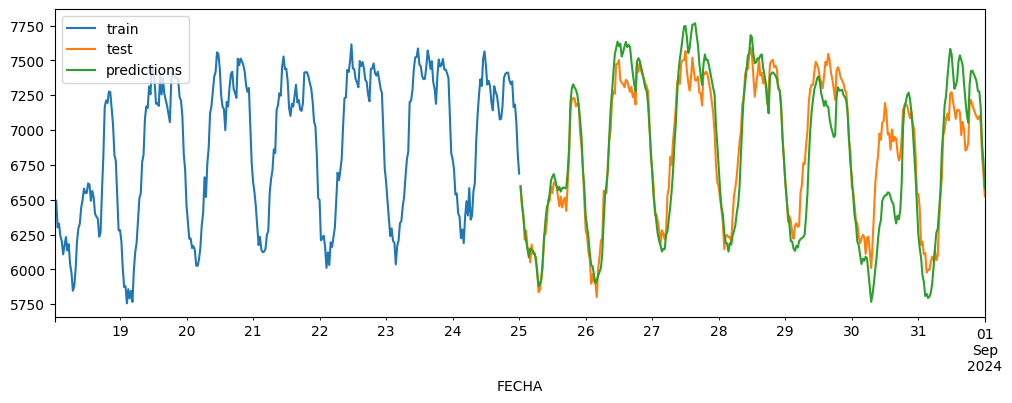

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
y_train[-steps:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

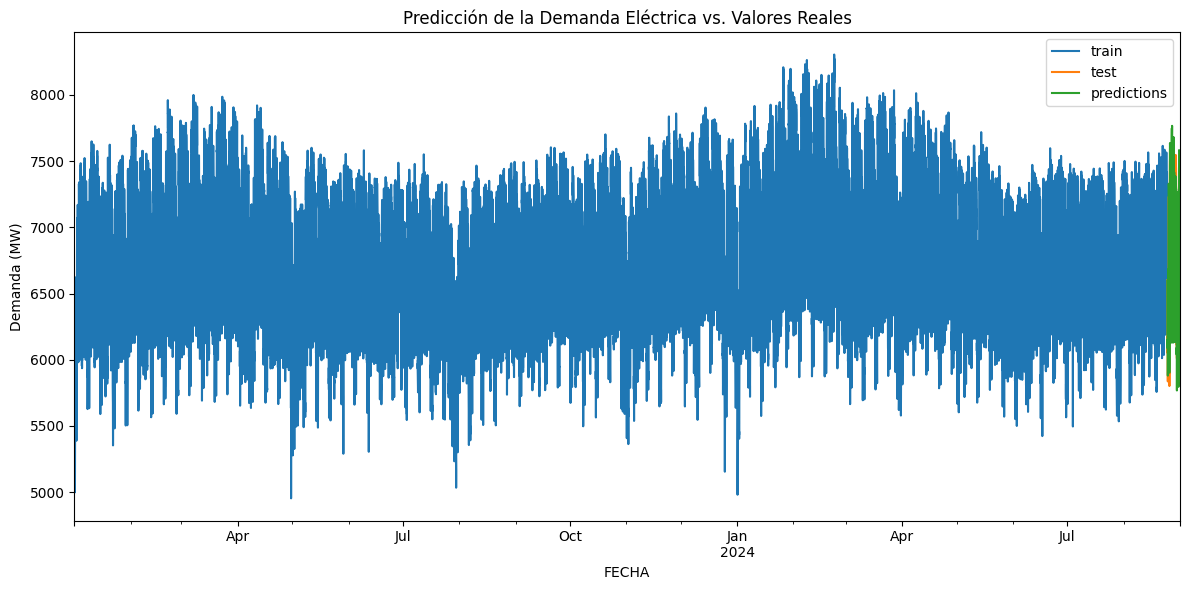

In [ ]:

# Gráfica de los resultados del modelo
import matplotlib.pyplot as plt

# Gráfica de los resultados del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))

# Trazar los datos de entrenamiento
y_train.plot(ax=ax, label='train', color='tab:blue')

# Trazar los datos de prueba
y_test.plot(ax=ax, label='test', color='tab:orange')

# Trazar las predicciones
predictions.plot(ax=ax, label='predictions', color='tab:green')

# Configuración adicional del gráfico
ax.set_title('Predicción de la Demanda Eléctrica vs. Valores Reales')
ax.set_xlabel('FECHA')
ax.set_ylabel('Demanda (MW)')

# Asegurar que el eje x muestre hasta la fecha del último dato
ax.set_xlim(left=y_train.index.min(), right=y_test.index.max())

ax.legend()
plt.tight_layout()
plt.show()


**Análisis de los resultados**

El objetivo de este código es entrenar un modelo de pronóstico con los mejores hiperparámetros y lags encontrados en el paso anterior y luego evaluar su rendimiento haciendo predicciones para el conjunto de datos de prueba, que son los valores reales de la última semana de la serie de tiempo.

El análisis de la gráfica muestra los siguientes resultados:

Línea azul (train): Representa los datos que el modelo utilizó para aprender los patrones de demanda.

Línea naranja (test): Muestra los valores reales de la demanda eléctrica para la última semana, que es el periodo que el modelo debe predecir.

Línea verde (predictions): Son los valores que el modelo ha pronosticado para la última semana.

Al comparar las líneas naranja (valores reales) y verde (predicciones), se puede concluir que el modelo ha capturado con éxito el patrón diario y semanal de la demanda. La línea verde de las predicciones sigue muy de cerca la forma de la línea naranja, replicando los picos altos durante el día y los valles bajos durante la noche.

Aunque la predicción sigue el patrón general de la serie, es importante notar que el modelo tiende a subestimar o sobrestimar ligeramente los picos y los valles de la demanda. Por ejemplo, en los días con mayor demanda, la línea verde no alcanza el pico de la línea naranja, y viceversa en los valles. Esto es común en los modelos de pronóstico, y los errores de predicción pueden ser causados por factores externos no incluidos en el modelo, como cambios en la temperatura o eventos inesperados.

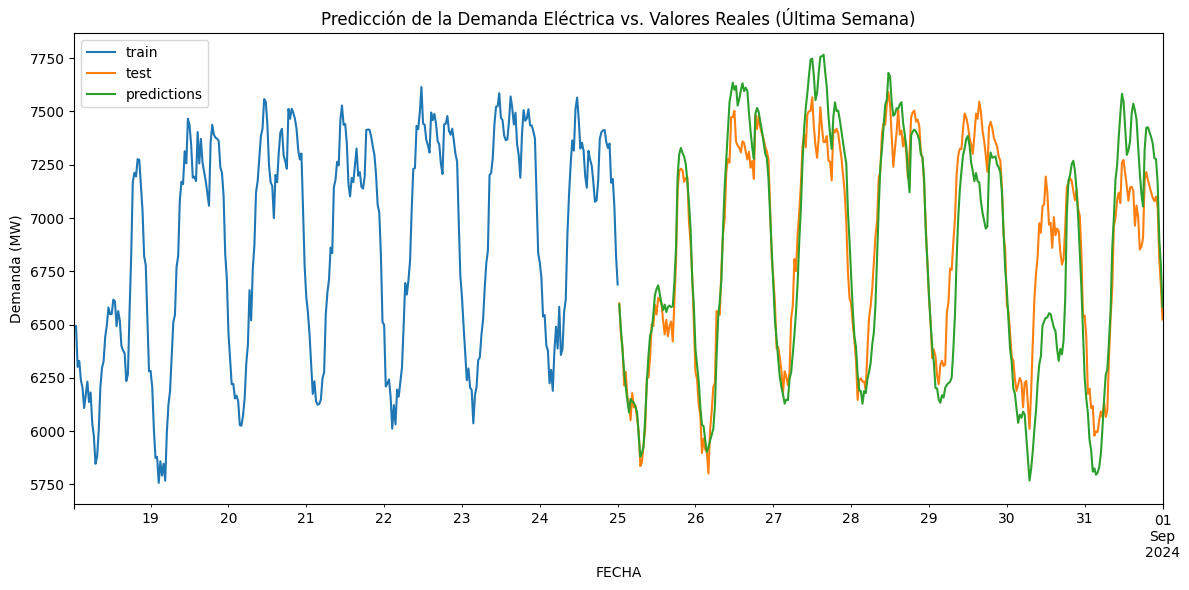

In [ ]:

# Gráfica de los resultados del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))

# Trazar los datos de entrenamiento de la última semana
y_train[-48*7:].plot(ax=ax, label='train', color='tab:blue')

# Trazar los datos de prueba
y_test.plot(ax=ax, label='test', color='tab:orange')

# Trazar las predicciones
predictions.plot(ax=ax, label='predictions', color='tab:green')

# Configuración adicional del gráfico
ax.set_title('Predicción de la Demanda Eléctrica vs. Valores Reales (Última Semana)')
ax.set_xlabel('FECHA')
ax.set_ylabel('Demanda (MW)')

# Ajustar el eje x para mostrar solo las últimas dos semanas
ax.set_xlim(left=y_train.index[-48*7], right=y_test.index.max())

ax.legend()
plt.tight_layout()
plt.show()

*Analisis de la grafica*

La gráfica muestra los datos de entrenamiento (train), los datos de prueba (test) y las predicciones del modelo (predictions) para la última semana.

La línea azul (train) representa la demanda histórica que el modelo usó para aprender.

La línea naranja (test) es la demanda real de la última semana que el modelo no ha visto.

La línea verde (predictions) es la predicción del modelo para esa misma semana.

El análisis de la gráfica revela que el modelo ha capturado con éxito el patrón diario y semanal de la demanda. La línea verde de las predicciones sigue muy de cerca la forma de la línea naranja, replicando los picos altos durante el día y los valles bajos durante la noche. Sin embargo, se puede observar que el modelo tiende a subestimar o sobrestimar ligeramente los picos y valles de la demanda en ciertos momentos. Esta ligera desviación es un área de oportunidad para mejorar el modelo.

In [ ]:
#Cálculo  del Error Cuadrático Medio (MSE) entre los valores reales y los valores predichos de la demanda eléctrica.

error_mse1 = mean_squared_error(
                y_true = y_test,
                y_pred = predictions
            )
print(f"Test error 1 (MSE): {error_mse1}")

Test error 1 (MSE): 47730.74608560428


El resultado, 47730.746, es la métrica que cuantifica el error promedio del modelo. Un valor de MSE alto indica que el modelo tiene errores de predicción significativos, lo que significa que las predicciones están, en promedio, bastante alejadas de los valores reales. Esto concuerda con lo que se pudo observar en la gráfica, donde el modelo autorregresivo univariado no lograba capturar de forma precisa los picos y valles extremos de la demanda.

In [ ]:
forecaster


=================== 
ForecasterRecursive 
=================== 
Regressor: XGBRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
Window features: None 
Window size: 96 
Series name: Demand 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2023-01-01 00:30:00'), Timestamp('2024-08-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 30min 
Regressor parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': 'cpu', 'early_stopping_rounds': None,
    'enable_categorical': False, 'eval_metric': None, 'feature_types': None,
    'feature_weights': None, 'gamma': None, 'grow_policy': None,
    'importance_type': None, 'interaction_constraints': None, 'learning_rate':
    None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None,
    'max_delta_step': None, 'max_depth': 8, 'max_leaves': None,
    'min_child_weight': None, 'missing': nan, 'monotone_constraints': None,
    'multi_strategy': None, 'n_estimators': 250, 'n_jobs': None,
    'num_parallel_tree': None, 'random_state': 123, 'reg_alpha': None,
    'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None,
    'subsample': None, 'tree_method': None, 'validate_parameters': None,
    'verbosity': None} 
fit_kwargs: {} 
Creation date: 2025-09-28 00:11:15 
Last fit date: 2025-09-28 00:11:37 
Skforecast version: 0.18.0 
Python version: 3.12.11 
Forecaster id: None

### Modelo Autorregresivo y Multivariado

In [ ]:
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 48
             )

In [ ]:


# Training and validation folds
cv = TimeSeriesFold(
      steps              = 48,#la evaluacion es por periodos de 1 dia
      initial_train_size = int(len(x_train) - steps),#inicamos la evaluacion desde hace una semana
      refit              = False,
      fixed_train_size   = False
    )

In [ ]:
#Candidate values for lags
lags_grid = [1, 48, 96]

In [ ]:
#Candidate values for regressor's hyperparameters
param_grid = { 'n_estimators': [250], 'max_depth': [3, 8] }

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [250],
    'max_depth': [3, 8]
}


In [ ]:
results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = y_train,
                    exog        = x_train,
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = True # se cambió a True, para que se note mejor la validadcion cruzada
                )

Number of models compared: 6.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
  Parameters: {'max_depth': 8, 'n_estimators': 250}
  Backtesting metric: 9949.319242464753


In [ ]:
#Probar con otros niveles de profundidad
regressor = XGBRegressor(n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 96
             )
forecaster.fit(y =y_train , exog =x_train)

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
#prediccion de los resultados
predictions = forecaster.predict(steps=steps, exog =x_test ) #se agrego la variable exog = x_test

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

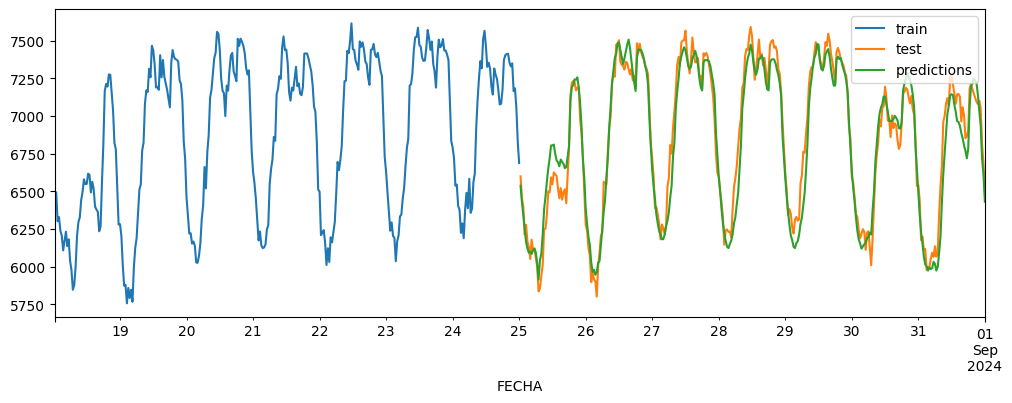

In [ ]:
#Graficar los resultados
#segunda prueba
fig, ax = plt.subplots(figsize=(12, 4))
y_train[-steps:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

Observación: En la gráfica se observa que se mejoró el resultado en comparación con el baseline(modelo univariado)

In [ ]:
#Calcular el error
error_mse2 = mean_squared_error(
                y_true = y_test,
                y_pred = predictions
            )
print(f"Test error 2 (MSE): {error_mse2}")

Test error 2 (MSE): 13268.475307510302


**Observaciones:**

El modelo multivariado mejora sustancialmente el desempeño

La reducción del MSE de 47,730 → 13,268 es significativa (≈ 72% de mejora en el error cuadrático medio).

Esto indica que las variables adicionales aportan información útil para predecir la demanda eléctrica.

**Valor agregado de las variables exógenas**

Los factores como día de la semana, feriados y posición en el día ayudan al modelo a capturar patrones recurrentes.

Esto es especialmente relevante en demanda eléctrica, donde existen ciclos diarios y semanales muy marcados.

El baseline es insuficiente para capturar estacionalidad

El modelo univariado (solo autoregresivo) no logra explicar bien los cambios de consumo, especialmente en picos y valles.

El multivariado sí los ajusta mejor, mostrando que la demanda depende de más que el pasado inmediato.

## Modelo Autorregresivo y Multivariado (con ajustes)

In [ ]:
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 48
             )

In [ ]:
# Training and validation folds
cv = TimeSeriesFold(
      steps              = 48,#la evaluacion es por periodos de 1 dia
      initial_train_size = int(len(x_train) - steps),#inicamos la evaluacion desde hace una semana
      refit              = False,
      fixed_train_size   = False
    )

In [ ]:
# Candidate values for lags
#lags_grid = [1, 48, 96]
lags_grid = [[1, 48, 96, 336]]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [250, 400],
    'max_depth': [5, 8, 12]
}

In [ ]:
results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = y_train,
                    exog        = x_train,
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = True # se cambió a True, para que se note mejor la validadcion cruzada
                )

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Information of folds
--------------------
Number of observations used for initial training: 28560
Number of observations used for backtesting: 336
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 48
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-01-01 00:30:00 -- 2024-08-18 00:00:00  (n=28560)
    Validation: 2024-08-18 00:30:00 -- 2024-08-19 00:00:00  (n=48)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-08-19 00:30:00 -- 2024-08-20 00:00:00  (n=48)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-20 00:30:00 -- 2024-08-21 00:00:00  (n=48)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-08-21 00:30:00 -- 2024-08-22 00:00:00  (n=48)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-08-22 00:30:00 -- 2024-08-23 00:00:00  (n=48)
Fold: 5
    Training:   No training in this fold
    Validati

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1  48  96 336] 
  Parameters: {'max_depth': 5, 'n_estimators': 250}
  Backtesting metric: 11383.03941386085


In [ ]:
#Probar con otros niveles de profundidad
regressor = XGBRegressor(n_estimators=250, max_depth=5, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 96 # probar luego con 96
             )
forecaster.fit(y =y_train , exog =x_train)



╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
#prediccion de los resultados
predictions = forecaster.predict(steps=steps, exog =x_test ) #se agrego la variable exog = x_test

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location : /usr/local/lib/python3.12/dist-packages/skforecast/utils/utils.py:641     │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

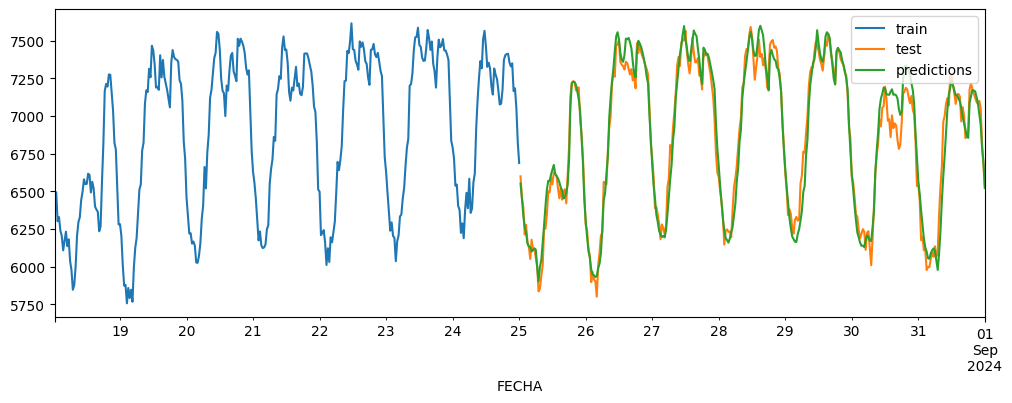

In [ ]:
#Graficar los resultados
#segunda prueba
fig, ax = plt.subplots(figsize=(12, 4))
y_train[-steps:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [ ]:
#Calcular el error
error_mse2 = mean_squared_error(
                y_true = y_test,
                y_pred = predictions
            )
print(f"Test error 2 (MSE): {error_mse2}")



Test error 2 (MSE): 9958.175699148667


Observaciones:
El modelo autorregresivo y multivariado ajustado es el mejor enfoque.
La optimización de lags y parámetros reduce el error de predicción a 9,958.18 MSE, ofreciendo un pronóstico mucho más preciso que el baseline.
Esto demuestra que en problemas de demanda eléctrica es crucial combinar histórico de consumo + variables exógenas + ajuste de hiperparámetros para lograr resultados de alta calidad.